<a href="https://www.kaggle.com/code/behhhoui/predicting-wild-blueberry-yields?scriptVersionId=133687092" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Info
This project predicts the yield of different blueberry plants. As an avid gardener who has accidentally killed 2 blueberry plants and has 2 surviving ones... this definitely intrigues me. The original competition and data documentation is [here](https://www.kaggle.com/competitions/playground-series-s3e14).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e14/sample_submission.csv
/kaggle/input/playground-series-s3e14/train.csv
/kaggle/input/playground-series-s3e14/test.csv


In [3]:
filepath = '/kaggle/input/playground-series-s3e14'

train = pd.read_csv('/kaggle/input/playground-series-s3e14/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e14/test.csv')

In [4]:
train.head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


* It looks like all features are numerical, and will require scaling
* Some features aren't very intuitive to me (Osmia? MaxOfUpperTRange) and there isn't much documentation in the competition link. After some quick Googling, seems like a few columns relate to bee species (Honeybee, Bumblebee, Andrena, Osmia).
* We're also missing features that I believe are very important to the blueberry plants outcome: soil pH (blueberries require slightly acidic soil, ph ~5), soil nutrients (all plants require at least N, Mg and P), age (too young / too old will be less fruitfull), sunny days, average summer temperature (too hot = bolting)

I'm not too optimistic of a model given these limitations... but let's try.

## EDA

In [5]:
# summary table function copied from https://www.kaggle.com/code/kimtaehun/simple-eda-and-baseline-in-2mintues

def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    
    return summ

In [6]:
summary(train)

data shape: (15289, 18)


,data type,#missing,%missing,#unique,min,max
id,int64,0,0.0,15289,0.000000,15288.000000
clonesize,float64,0,0.0,6,10.000000,40.000000
honeybee,float64,0,0.0,7,0.000000,18.430000
bumbles,float64,0,0.0,11,0.000000,0.585000
andrena,float64,0,0.0,16,0.000000,0.750000
osmia,float64,0,0.0,14,0.000000,0.750000
MaxOfUpperTRange,float64,0,0.0,6,69.700000,94.600000
MinOfUpperTRange,float64,0,0.0,5,39.000000,57.200000
AverageOfUpperTRange,float64,0,0.0,5,58.200000,79.000000
MaxOfLowerTRange,float64,0,0.0,6,50.200000,68.200000


#### Relationships and correlations

In [7]:
train.columns

Index(['id', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')

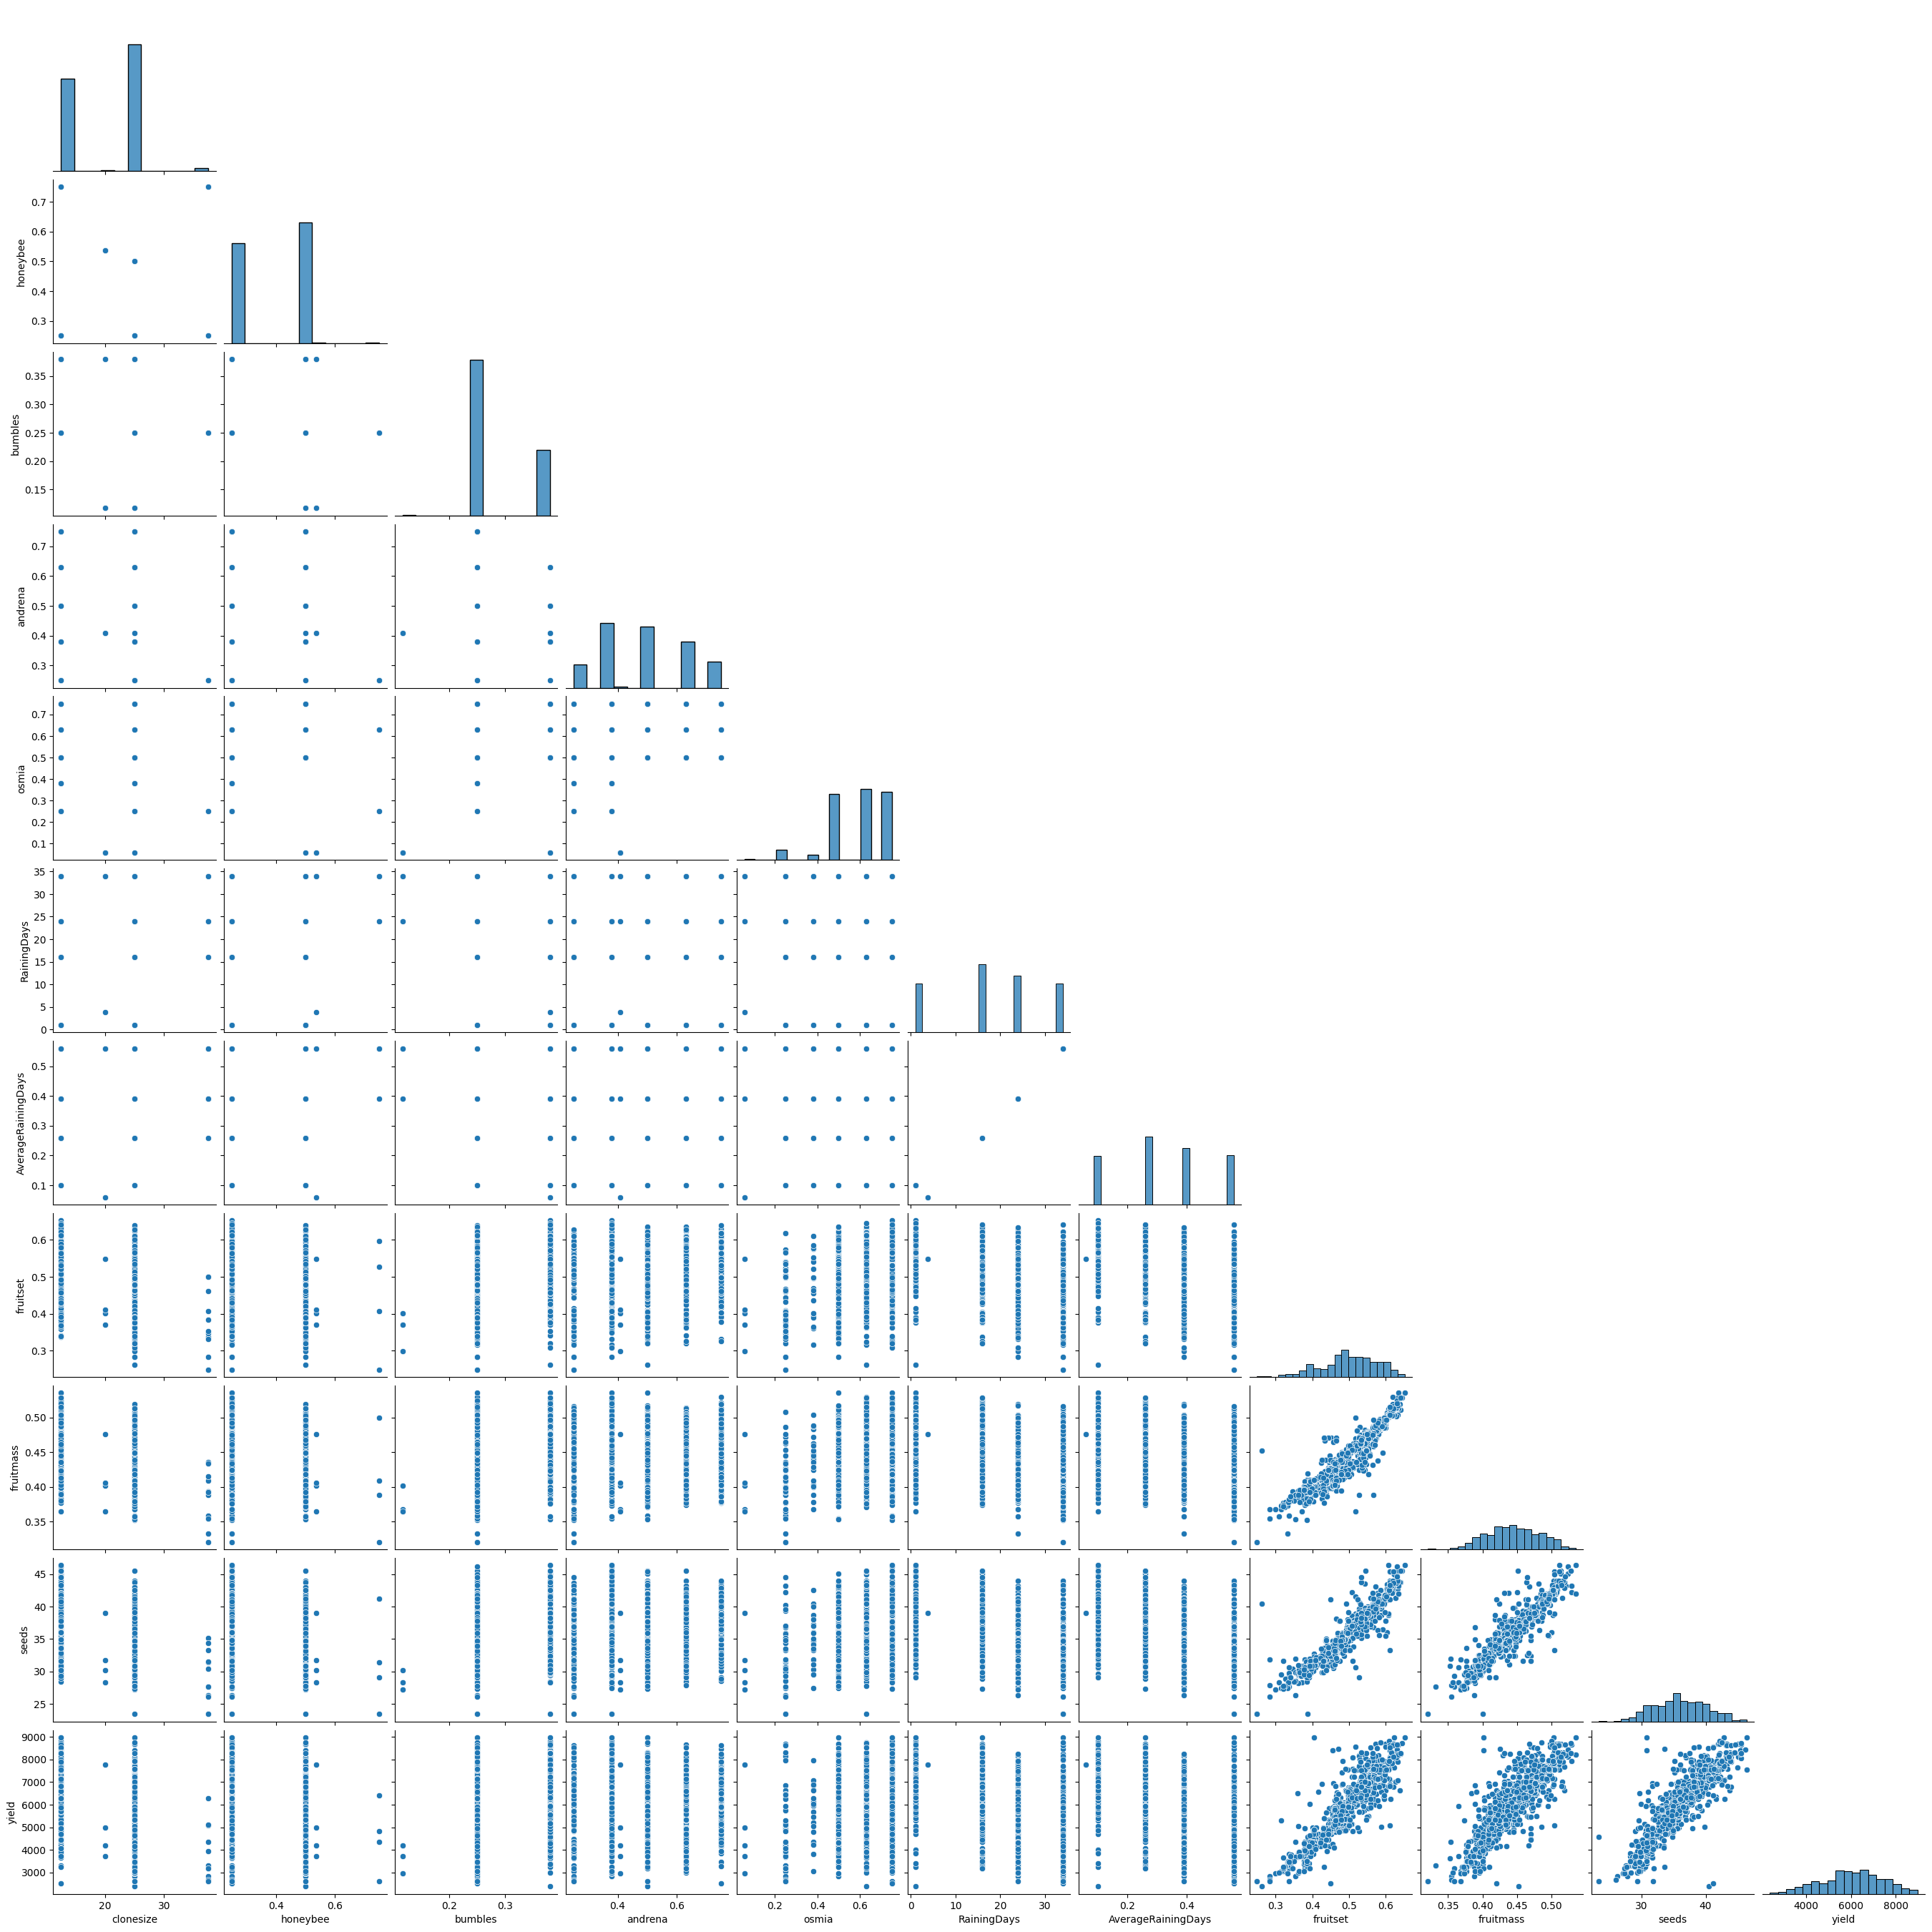

In [8]:
train_visualize = train.drop(columns=['id', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange']) #removing potentially unhelpful columns from visual
sns.pairplot(train_visualize.sample(1000), corner=True) #visualize a sample of data, to speed up

* Yield distribution is fairly normal
* Not many features seem correlated with yield except `fruitset`, `fruitmass` and `seeds`. All other features have fairly low cardinality.

## Prepare model

In [9]:
from sklearn.preprocessing import StandardScaler
 
scaler= StandardScaler()
 
scaled = scaler.fit_transform(train.drop('id', axis=1)) 
scaled = pd.DataFrame(scaled, columns=train.columns.drop('id'))
print(scaled)

       clonesize  honeybee   bumbles   andrena     osmia  MaxOfUpperTRange  \
0       0.802929  0.306073 -0.613664  1.737386 -0.662120         -1.363365   
1       0.802929  0.306073 -0.613664  0.049454 -0.662120         -1.363365   
2      -1.092448 -0.385238 -0.613664  0.927179  0.269883          0.418756   
3      -1.092448 -0.385238 -0.613664  0.927179 -0.662120         -0.521504   
4       0.802929  0.306073 -0.613664  0.927179  0.269883         -0.521504   
...          ...       ...       ...       ...       ...               ...   
15284  -1.092448 -0.385238 -0.613664 -0.760754 -0.662120         -0.521504   
15285  -1.092448 -0.385238 -0.613664 -1.638479 -0.662120          0.418756   
15286   0.802929  0.306073 -0.613664 -0.760754  1.130194         -0.521504   
15287   0.802929  0.306073 -0.613664  0.927179  0.269883         -1.363365   
15288   0.802929  0.306073 -0.613664  0.927179 -0.662120         -0.521504   

       MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange

In [10]:
scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   clonesize             15289 non-null  float64
 1   honeybee              15289 non-null  float64
 2   bumbles               15289 non-null  float64
 3   andrena               15289 non-null  float64
 4   osmia                 15289 non-null  float64
 5   MaxOfUpperTRange      15289 non-null  float64
 6   MinOfUpperTRange      15289 non-null  float64
 7   AverageOfUpperTRange  15289 non-null  float64
 8   MaxOfLowerTRange      15289 non-null  float64
 9   MinOfLowerTRange      15289 non-null  float64
 10  AverageOfLowerTRange  15289 non-null  float64
 11  RainingDays           15289 non-null  float64
 12  AverageRainingDays    15289 non-null  float64
 13  fruitset              15289 non-null  float64
 14  fruitmass             15289 non-null  float64
 15  seeds              

In [11]:
from sklearn.model_selection import train_test_split

# Extract feature and target arrays
X, y = scaled.drop(columns=['yield'], axis=1), scaled[['yield']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [12]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [13]:
model.predict(X_test)

array([ 0.2833526 , -0.6297146 ,  1.0823377 , ..., -1.0102372 ,
       -0.15899223,  0.81622654], dtype=float32)